In [7]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

In [8]:
df = pd.read_csv("../data/BrentOilPrices.csv")
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.sort_values("Date").reset_index(drop=True)

df["log_price"] = np.log(df["Price"])
df["log_return"] = df["log_price"].diff()
df = df.dropna()

returns = df["log_return"].values
n = len(returns)


C:\Users\hp\AppData\Local\Temp\ipykernel_28668\3518867882.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


In [9]:
with pm.Model() as model:

    # Prior for change point (tau)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n-1)

    # Priors for means before and after
    mu1 = pm.Normal("mu1", mu=0, sigma=0.1)
    mu2 = pm.Normal("mu2", mu=0, sigma=0.1)

    # Shared standard deviation
    sigma = pm.HalfNormal("sigma", sigma=0.1)

    # Switch mean
    mu = pm.math.switch(tau >= np.arange(n), mu1, mu2)

    # Likelihood
    likelihood = pm.Normal("obs", mu=mu, sigma=sigma, observed=returns)


In [10]:
with model:
    trace = pm.sample(100, tune=50, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma]


Output()

Sampling 4 chains for 50 tune and 100 draw iterations (200 + 400 draws total) took 1719 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [11]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,4506.088,5.577,4498.000,4518.000,2.306,1.242,6.0,20.0,1.79
mu1,0.000,0.000,-0.001,0.001,0.000,0.000,360.0,193.0,1.02
mu2,0.000,0.000,-0.001,0.001,0.000,0.000,327.0,276.0,1.01
sigma,0.029,0.004,0.025,0.038,0.002,0.001,7.0,25.0,1.78


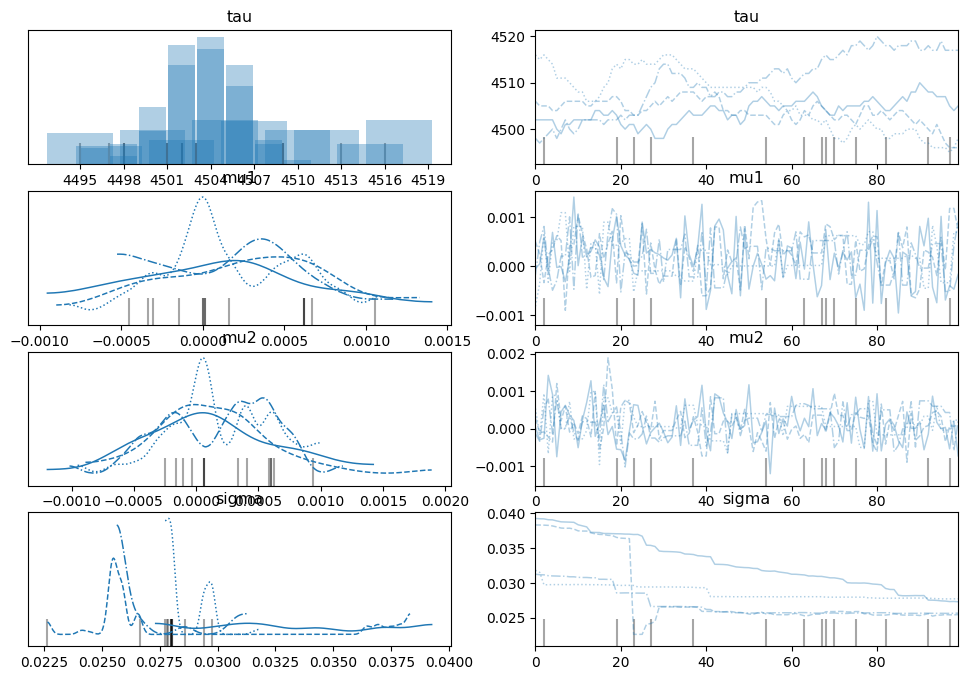

In [12]:
az.plot_trace(trace)
plt.show()


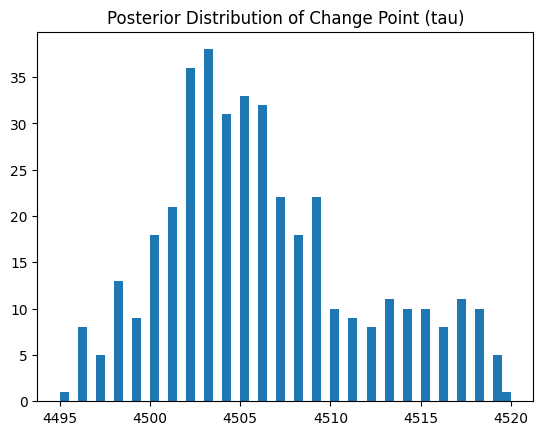

In [13]:
tau_samples = trace.posterior["tau"].values.flatten()

plt.hist(tau_samples, bins=50)
plt.title("Posterior Distribution of Change Point (tau)")
plt.show()


In [14]:
change_point_index = int(np.mean(tau_samples))
change_point_date = df["Date"].iloc[change_point_index]

print("Estimated Change Point Date:", change_point_date)

Estimated Change Point Date: 2005-02-04 00:00:00


In [15]:
mu1_mean = trace.posterior["mu1"].mean().values
mu2_mean = trace.posterior["mu2"].mean().values

In [16]:
percent_change = (mu2_mean - mu1_mean) / abs(mu1_mean) * 100

In [17]:
with pm.Model() as advanced_model:

    # Change point prior
    tau = pm.DiscreteUniform("tau", lower=0, upper=n-1)

    # Means before and after
    mu1 = pm.Normal("mu1", mu=0, sigma=0.05)
    mu2 = pm.Normal("mu2", mu=0, sigma=0.05)

    # Volatility before and after
    sigma1 = pm.HalfNormal("sigma1", sigma=0.05)
    sigma2 = pm.HalfNormal("sigma2", sigma=0.05)

    # Switch mean
    mu = pm.math.switch(tau >= np.arange(n), mu1, mu2)

    # Switch volatility
    sigma = pm.math.switch(tau >= np.arange(n), sigma1, sigma2)

    # Likelihood
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=returns)


In [ ]:
with advanced_model:
    advanced_trace = pm.sample(100, tune=50, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma1, sigma2]


Output()

In [ ]:
tau_samples = advanced_trace.posterior["tau"].values.flatten()
tau_est = int(np.mean(tau_samples))

change_point_date = df["Date"].iloc[tau_est]


In [ ]:
sigma1_mean = advanced_trace.posterior["sigma1"].mean().values
sigma2_mean = advanced_trace.posterior["sigma2"].mean().values

In [ ]:
az.waic(trace)
az.waic(advanced_trace)